## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Schrödinger com os kets, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10. Para melhor coerência dos resultados, a otimização será utilizada para substituir na variável independente da função objetivo e ainda será normalizada para que as comparações tenham o mesmo peso.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

Para uma aproximação ótima, utiliza-se um passo de integração (fator do Runge Kutta) com o valor de 0.01, prevendo um milésimo a frente, mas para uma aplicação real a intenção é o aumento dessa fator para uma produção mais real.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01 # Passo de Integração

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]
ondaOrigem = [[complex(1.0,0.0)],[complex(0.0,0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

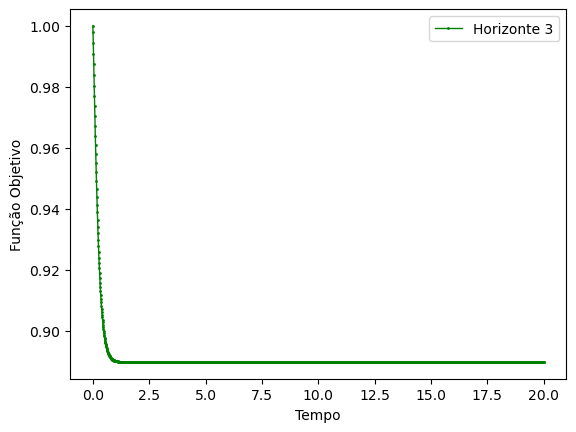

In [4]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.legend(loc="upper right")
plt.show()

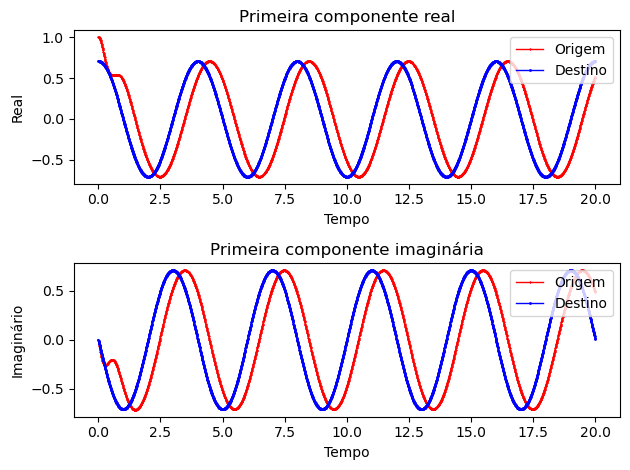

In [5]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()


In [6]:
horizonte = 3
fatorRungeKutta = 0.01 # Passo de Integração

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]
ondaOrigem = [[complex(1.0,0.0)],[complex(0.0,0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/np.sqrt(2)), (1/np.sqrt(2))], [(1/np.sqrt(2)), -(1/np.sqrt(2))]]

A = (1/2*np.pi)
B = (3/2*np.pi)

I = [[1, 0], [0, 1]]
R = [[1, 0], [0, 1]]
H = [[A, 0], [0, B]]

iteracao = 0
tempoFinal = 20
tempoInicial = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    hamiltoniano = [[(1/np.sqrt(2)), (1/np.sqrt(2))], [(1/np.sqrt(2)), -(1/np.sqrt(2))]]

    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

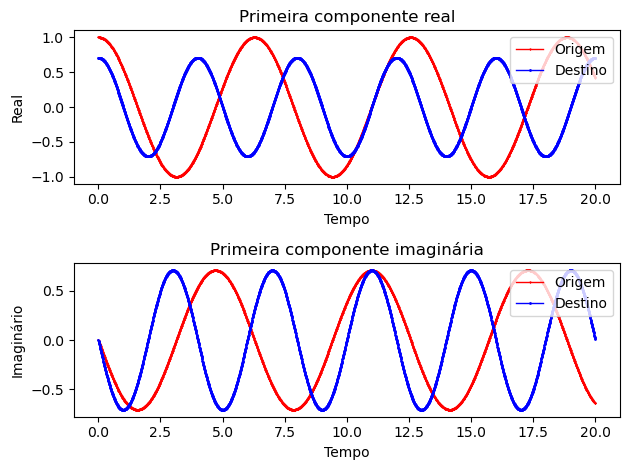

In [7]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()